<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gaussian-mixture" data-toc-modified-id="Gaussian-mixture-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Gaussian mixture</a></span></li><li><span><a href="#Data-generation-and-plot" data-toc-modified-id="Data-generation-and-plot-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data generation and plot</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Testing</a></span></li></ul></div>

# Gaussian mixture

This is the implementation of our full gaussian mixture algorithm.
The best lecture I found is http://people.csail.mit.edu/dsontag/courses/ml12/slides/lecture21.pdf .
In guassian mixture model, we assume the all examples are generated in probability of $n$ components

$$
\sum_k^n \frac{p_k}{2\pi\sqrt{|\sigma_k|}}e^{-(X-\mu_k)^T\sigma^{-1}_k(X-\mu_k)}
$$
where 
$p_k$ is a probability of $k$ components. And we have $\sum_k p_k = 1$.
The $\sigma_k$ is $n_f\times n_f$ semi-defined matrix. where $n_f$ is the number of features, or the dimension of an example. The $|\sigma_k|$ is the determine of $\sigma_k$.


The optimization problems is solved EM algorithm.

In [1]:
import numpy as np
class GaussianMixture:
    def __init__(self, n_components=1,max_iter=100,random_state=42):
        self.n_components=n_components
        self.max_iter=max_iter
        self.random_state=np.random.RandomState(random_state)
        
        
    def cal_com_weights(self, X, ps, mus, sigmas):
        ncom= ps.shape[-1]
        nfeature = X.shape[-1]
        ndata = X.shape[-2]
        
        # [ndata, ncom, nfeature]
        xd = X[:,np.newaxis,:] - mus
        assert xd.shape == (ndata, ncom, nfeature)
        # [ncom, nfeature, nfeature]
        invsigmas = np.linalg.inv(sigmas)
        assert invsigmas.shape == (ncom, nfeature, nfeature)

        # [ndata, ncom, nfeature]
        invxd = np.sum(invsigmas*xd[:,:,np.newaxis,:], axis=-1)            
        assert invxd.shape == (ndata, ncom, nfeature), invxd.shape

        det = np.linalg.det(sigmas)

        # [ndata, ncom]
        g = ps/np.sqrt(det)*np.exp(-np.sum(xd*invxd, axis=-1))
        assert g.shape == (ndata, ncom), g.shape

        # [ndata]
        n = np.sum(g, axis=-1)
        assert n.shape == (ndata,), n.shape
        # [ndata, ncom]
        P = g / n[:,np.newaxis]
        #print("P", P)
        return P
        
    def fit(self,X):
        # [ndata, nfeature]
        # X
        assert X.ndim >= 2        
        means=np.mean(X, axis=-2)
        stds = np.std(X, axis=-2)
        n_components = self.n_components
        ncom= n_components
        nfeature = X.shape[-1]
        ndata = X.shape[-2]
        
        # [ncom, nfeature]
        mus = means + stds*self.random_state.randn(n_components, means.shape[-1])        
        #print(mus)
        # [ncom]
        ps = np.ones(n_components)/n_components        
        # [ncom, nfeature, nfeature]
        sigmas = np.tile(np.diag(stds), (n_components, 1, 1))
        #print(sigmas)
        
        
        # the best lecture I found http://people.csail.mit.edu/dsontag/courses/ml12/slides/lecture21.pdf        
        for n_iter in range(self.max_iter):
            
            # [ndata, ncom, nfeature]
            xd = X[:,np.newaxis,:] - mus
            
            # [ndata, ncom]
            P = self.cal_com_weights(X, ps, mus, sigmas)
            # [ncom]
            N = np.sum(P, axis=-2)
                       
            ps = N/X.shape[-2]            
            #print("ps", ps)
            
            # [ncom, nfeature]
            mus = np.einsum("ij,ik->jk", P, X) / N[:,np.newaxis]
            #print(mus)
                        
            
            #[ndata, ncom, nfeature, nfeature]
            xcov = np.einsum("ijk,ijl->ijkl", xd, xd)
            assert xcov.shape == (ndata, ncom, nfeature, nfeature), xcov.shape
            sigmas = np.einsum("ij,ijkl->jkl", P, xcov) / N[:,np.newaxis, np.newaxis]
            #print(sigmas)
            
        self.weights_ = ps
        self.means_ = mus
        self.covariances_ = sigmas
        
    def predict(self, X):
        # [ndata, ncom]
        P = self.cal_com_weights(X, self.weights_, self.means_, self.covariances_)
        argmax = np.argmax(P, axis=-1)
        return argmax
        
        
    
    

# Data generation and plot

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gen_data(center, n=200, random_state=1):
    rnd = np.random.RandomState(random_state)

    if isinstance(n, int):
        Xs = [rnd.randn(n, 2) + c for c in center]
        ys = [np.full(n, i) for i in range(len(center))]
    else:
        assert len(n) == len(center), n
        Xs = [rnd.randn(n_, 2) + c for c, n_ in zip(center, n)]
        ys = [np.full(n_, i) for i, n_ in enumerate(n)]

    X = np.vstack(Xs)
    y = np.hstack(ys)
    pert = np.random.permutation(X.shape[0])
    X = X[pert]
    y = y[pert]

    return X, y


def plot_data(X, y):
    plt.figure(figsize=(5, 5))
    nlabels = int(np.amax(y) + 1)
    for i in range(nlabels):
        plt.scatter(X[y == i, 0], X[y == i, 1])

    plt.show()


# Testing

We generate a dataset in four categories. In each category, the examples are distributed in gaussian distribution. Then we use our `GaussianMixture` class to classify all examples into four categories without seeing the actual labels.

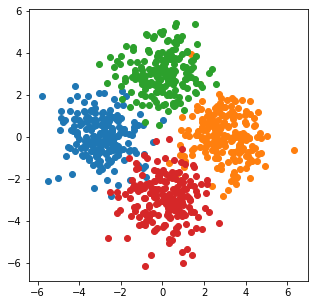

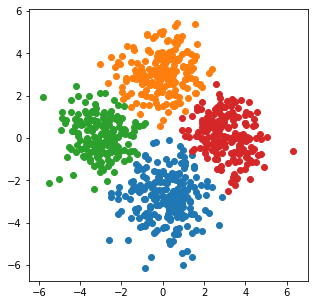

In [3]:
def test_GaussianMixture(center):
    X,y=gen_data(center, n=200)
    plot_data(X, y)
    gm=GaussianMixture(n_components=4, max_iter=100)
    gm.fit(X)
    y=gm.predict(X)
    plot_data(X, y)
    
test_GaussianMixture(np.array([[-3,0],[3,0],[0,3],[0,-3]]))